<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step3-generate_results-cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate results from model
--- 

Here we will process the qualifying tilts identified in the `step 2` notebook (0.05, 0.1313, 0.2125) with contrasts of 0.3, .45, and 1. 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 21 19:52:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 1: Setup the model
This model was created using the `step1_train` Jupyter notebook. 
Run the cell to download a zip file from OSF then extract its contents into the newly created directory.

vanilla gabor model: `content/van_gabor/`

In [3]:
# @title Download model

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `vanilla model trained on Gabors`...")
name = 'van_gabor_model'
fname = f"{name}.zip"
url = f"https://osf.io/3wqsf/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall() #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `vanilla model trained on Gabors`...
Download completed.


#### Load the model
Next, we load the model using Tensorflow

In [4]:
import tensorflow as tf 
import pandas as pd
tf.random.set_seed(42) #set random seed for reproducibility
model = tf.keras.models.load_model('van_gabor') 
#model = tf.keras.models.load_model('van_gabor') 
model.summary() #verify architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 160)     1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 160)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 160)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 80)        115280    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 80)       0

## 2: Download & load datasets to test model with
Download the test datasets from OSF and extract the contents into the newly created directory: `content/datasets/`

In [5]:
# @title Download datasets

print("Start downloading and unzipping `9 datasets`...")
name = 'tilt_contrast-van_gabor'
fname = f"{name}.zip"
url = f"https://osf.io/wc3nr/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall("datasets") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

Start downloading and unzipping `9 datasets`...
Download completed.


Load all 9 sets and use prefetch to streamline image loading

In [6]:
# @title Load datasets into tensorflow

from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32 
IMG_SIZE = (160, 160) #forces a resize from 170x170 since MobileNetV2 has weights only for certain sizes
AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
def model2_init_sets(BATCH_SIZE, IMG_SIZE, AUTOTUNE):
    curr_dir = os.getcwd() 
    set1_dir = os.path.join(curr_dir, 'datasets/t_0_05-c_0_3')
    set2_dir = os.path.join(curr_dir, 'datasets/t_0_05-c_0_45')
    set3_dir = os.path.join(curr_dir, 'datasets/t_0_05-c_1')
    set4_dir = os.path.join(curr_dir, 'datasets/t_0_1313-c_0_3')
    set5_dir = os.path.join(curr_dir, 'datasets/t_0_1313-c_0_45')
    set6_dir = os.path.join(curr_dir, 'datasets/t_0_1313-c_1')
    set7_dir = os.path.join(curr_dir, 'datasets/t_0_2125-c_0_3')
    set8_dir = os.path.join(curr_dir, 'datasets/t_0_2125-c_0_45')
    set9_dir = os.path.join(curr_dir, 'datasets/t_0_2125-c_1')
    set1 = image_dataset_from_directory(set1_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale') #2000 images 2 classes
    set2 = image_dataset_from_directory(set2_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')    
    set3 = image_dataset_from_directory(set3_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    set4 = image_dataset_from_directory(set4_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    set5 = image_dataset_from_directory(set5_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    set6 = image_dataset_from_directory(set6_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    set7 = image_dataset_from_directory(set7_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale') 
    set8 = image_dataset_from_directory(set8_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    set9 = image_dataset_from_directory(set9_dir, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode='grayscale')
    class_names = set1.class_names #extract class names loading function inferred from subdir's
    set1 = set1.prefetch(buffer_size=AUTOTUNE) 
    set2 = set2.prefetch(buffer_size=AUTOTUNE) 
    set3 = set3.prefetch(buffer_size=AUTOTUNE) 
    set4 = set4.prefetch(buffer_size=AUTOTUNE) 
    set5 = set5.prefetch(buffer_size=AUTOTUNE) 
    set6 = set6.prefetch(buffer_size=AUTOTUNE) 
    set7 = set7.prefetch(buffer_size=AUTOTUNE) 
    set8 = set8.prefetch(buffer_size=AUTOTUNE) 
    set9 = set9.prefetch(buffer_size=AUTOTUNE) 
    return set1,set2,set3,set4,set5,set6,set7,set8,set9,class_names

set1,set2,set3,set4,set5,set6,set7,set8,set9,class_names = model2_init_sets(BATCH_SIZE, IMG_SIZE, AUTOTUNE)

Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


##3: Generate logits
First, we can define a function for generating logits from a dataset.

In [7]:
from scipy.special import expit #import sigmoid func
import numpy as np
def process_dataset(dataset, model):
    all_logits=tf.zeros([], tf.float64) #initialize array to hold all prediction logits (single element)
    all_labels=tf.zeros([], tf.float64) #initialize array to hold all actual labels (single element)
    for image_batch, label_batch in dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten() #run batch through model and return logits
        all_logits = tf.experimental.numpy.append(all_logits, predictions)
        all_labels = tf.experimental.numpy.append(all_labels, label_batch)
    #tf.size(all_pred) #1335 elements, 1334 images + 1 placeholder 0 at beginning
    all_logits = all_logits[1:]
    all_labels = all_labels[1:]
    all_logits_sig = expit(all_logits) #sigmoid-transform the logits
    all_pred = np.where((all_logits_sig < 0.5), 0, 1) #replace predictions with 0 or 1
    all_acc = np.where((all_pred == all_labels), 1, 0) #decide whether pred = label
    return all_logits,all_labels,all_pred,all_acc

Let's test it on the first dataset:

In [16]:
all_logits,all_labels,all_pred,all_acc = process_dataset(set1,model)

In [17]:
all_logits.numpy()[:5] #first five logits, of 4000

array([ 0.40684351, -0.25541946,  0.43645689,  0.0385733 , -0.8680746 ])

In [18]:
np.absolute(all_logits.numpy()).mean() #avg raw confidence

0.7660694523281272

In [19]:
all_acc.mean() #avg accuracy

0.54225

In [20]:
all_pred.shape

(4000,)

In [21]:
all_labels.numpy()[:5] #first five labels, of 4000

array([0., 0., 0., 0., 0.])

In [22]:
tilts = np.repeat(0.05, all_pred.size)
contrasts = np.repeat(0.3, all_pred.size)

Looks good. Now, we can add it to a pandas dataframe.

In [23]:
df = pd.DataFrame({'Logits':all_logits.numpy(),'Labels':all_labels.numpy(),
                   'Predictions':all_pred,'Accuracy':all_acc,'Tilt':tilts,
                   'Contrast':contrasts})
df.head()

,Logits,Labels,Predictions,Accuracy,Tilt,Contrast
0,0.406844,0.0,1,0,0.05,0.3
1,-0.255419,0.0,0,1,0.05,0.3
2,0.436457,0.0,1,0,0.05,0.3
3,0.038573,0.0,1,0,0.05,0.3
4,-0.868075,0.0,0,1,0.05,0.3


Next, let's process all 9 datasets. We will stack each sets' 4,000 logits in a single dataframe, `df`. The resulting dataframe will have 36,000 logits resulting from vertically stacking the logits for set1, set 2, .., set9. Additionally, we will calculate the average raw confidence and accuracy scores for each tilt/contrast combination and save this in a separate dataframe called `df_results`.

In [24]:
df = pd.DataFrame(columns=['Logits','Labels','Predictions','Accuracy','Tilt',
                           'Contrast']) #init dataframe
df_results = pd.DataFrame(columns=['Accuracy','Confidence']) #init dataframe
all_sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9]
all_tilts = [0.05, 0.05, 0.05, 0.1313, 0.1313, 0.1313, 0.2125, 0.2125, 0.2125]
all_contrasts = [0.3, 0.45, 1, 0.3, 0.45, 1, 0.3, 0.45, 1]
for idx, dataset in enumerate(all_sets): #run for all sets:
    tilt = all_tilts[idx]
    contrast = all_contrasts[idx]
    all_logits,all_labels,all_pred,all_acc = process_dataset(dataset, model)
    tilts = np.repeat(tilt, all_pred.size)
    contrasts = np.repeat(contrast, all_pred.size)
    df = pd.concat([df, pd.DataFrame({'Logits':all_logits.numpy(),
                                      'Labels':all_labels.numpy(),
                                      'Predictions':all_pred,'Accuracy':all_acc,
                                      'Tilt':tilts,'Contrast':contrasts})], 
                  axis=0, ignore_index=True) #append logits, labels,etc to dataframe
    acc = all_acc.mean() #calculate avg accuracy
    conf = np.absolute(all_logits.numpy()).mean()
    df_results = pd.concat([df_results, pd.DataFrame({'Accuracy':[acc],
                                                'Confidence':[conf],
                                                'Tilt':tilt,'Contrast':contrast})], 
                      axis=0, ignore_index=True) #append acc & conf to dataframe

In [25]:
df.shape

(36000, 6)

In [26]:
df.head()

,Logits,Labels,Predictions,Accuracy,Tilt,Contrast
0,0.406844,0.0,1,0,0.05,0.3
1,-0.255419,0.0,0,1,0.05,0.3
2,0.436457,0.0,1,0,0.05,0.3
3,0.038573,0.0,1,0,0.05,0.3
4,-0.868075,0.0,0,1,0.05,0.3


In [27]:
df[3990:4005]

,Logits,Labels,Predictions,Accuracy,Tilt,Contrast
3990,-0.660117,1.0,0,0,0.05,0.30
3991,-0.729833,1.0,0,0,0.05,0.30
3992,0.734755,1.0,1,1,0.05,0.30
3993,-0.739299,1.0,0,0,0.05,0.30
3994,-1.144405,1.0,0,0,0.05,0.30
3995,0.469699,1.0,1,1,0.05,0.30
3996,-1.761150,1.0,0,0,0.05,0.30
3997,0.441849,1.0,1,1,0.05,0.30
3998,-0.275277,1.0,0,0,0.05,0.30
3999,1.392085,1.0,1,1,0.05,0.30


In [28]:
df_results_groupbyta = df_results.reset_index().set_index(['Tilt','Contrast'])
del df_results_groupbyta['index']
df_results_groupbyta

Accuracy  Confidence
Tilt   Contrast                      
0.0500 0.30       0.54225    0.766069
       0.45       0.58050    0.806112
       1.00       0.65950    0.868622
0.1313 0.30       0.61350    0.788609
       0.45       0.66050    0.858153
       1.00       0.85975    1.241022
0.2125 0.30       0.69500    0.829591
       0.45       0.78000    1.025102
       1.00       0.96000    1.768114

It looks like there is a slight dissociation between tilt 0.1313 contrast 0.45 and tilt 0.2125 contrast 0.3.

Now we can save both dataframes as excel files.

In [29]:
logits_excel_filepath = os.path.join(os.getcwd(), 'logits-van_gabor.xlsx') #prep path to save to
df.to_excel(logits_excel_filepath, index=False) #save to disk
results_excel_filepath = os.path.join(os.getcwd(), 'results-van_gabor.xlsx') #prep path to save to
df_results_groupbyta.to_excel(results_excel_filepath, index=True) #save to disk

In [30]:
from google.colab import files
files.download('logits-van_gabor.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##4: Visualize the logits
First, let's the class names and insert them into the dataframe for visualization:

In [31]:
class_names

['cclock', 'clock']

In [32]:
df.replace({'Labels': {0: class_names[0], 1: class_names[1]}}, inplace=True) #change 0/1 classes to cclock & clock

We can plot a histogram of the logits across all the datasets using Seaborn. Counterclockwise (cclock) tilts are represented as blue and clockwise (clock) tilts are represented as orange.

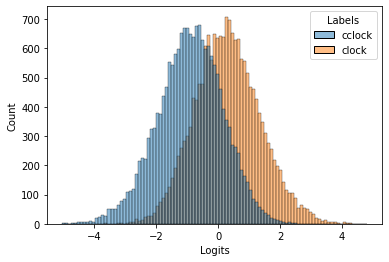

In [33]:
import seaborn as sns
sns.histplot(data=df, x="Logits", hue="Labels")

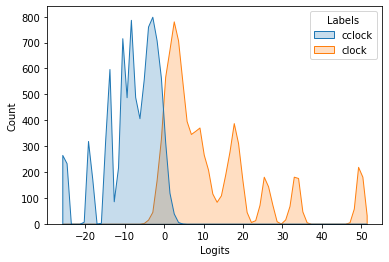

In [ ]:
sns.histplot(data=df, x="Logits", hue="Labels", element="poly") #old model v1

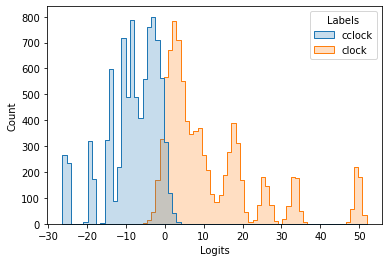

In [ ]:
sns.histplot(data=df, x="Logits", hue="Labels", element="step") #v1 model

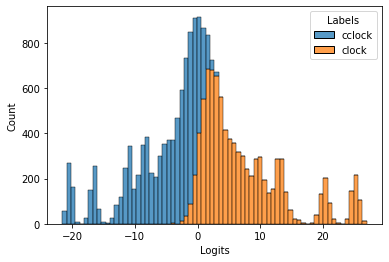

In [ ]:
sns.histplot(data=df, x="Logits", hue="Labels", multiple="stack") #v3 model

This one looks best. Let's increase its size and save the figure as a high resolution transparent png.

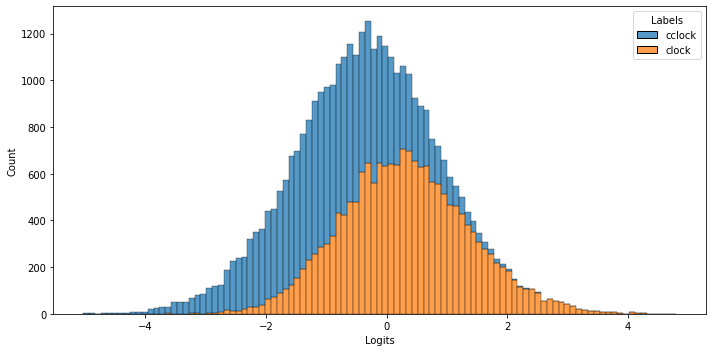

In [34]:
import matplotlib.pyplot as plt
lfig = sns.histplot(data=df, x="Logits", hue="Labels", multiple="stack")
fig=plt.gcf()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.savefig('logits-van_gabor.png', transparent=True, dpi=300)

In [35]:
files.download('logits-van_gabor.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>